In [1]:
import pandas as pd
import jax.numpy as jnp
import evofr as ef
import numpy as np

In [4]:
# Getting data
raw_cases = pd.read_csv("../mpox_build/cluster_assignment/monkeypox_data.csv")
#raw_cases = raw_cases.rename(columns = {"&nbsp;": "cases"})
raw_cases["region"] = "LA"
raw_cases

,date,cases,region
0,2022-05-19,1,LA
1,2022-05-20,0,LA
2,2022-05-21,0,LA
3,2022-05-22,0,LA
4,2022-05-23,0,LA
...,...,...,...
864,2024-09-29,0,LA
865,2024-09-30,1,LA
866,2024-10-01,0,LA
867,2024-10-02,0,LA


In [19]:
region = {'Canada':'North America',
          'United States':'North America',
         'Finland':'Northern Europe',
           'Austria': 'Western Europe',
        'Germany':'Western Europe', 
        'Switzerland':'Western Europe',
         'United Kingdom':'Western Europe',
        'France':'Western Europe',
        'Belgium':'Western Europe',
        'Netherlands':'Western Europe',
        'Slovakia':'Central Europe',
        'Slovenia':'Central Europe',
        'Italy':'Southern Europe',
        'Portugal':'Southern Europe',
        'Spain':'Southern Europe',
         'Colombia':'South America',
          
        'Peru':'South America'}

In [5]:
raw_cases = raw_cases.dropna()
raw_cases

,date,cases,region
0,2022-05-19,1,LA
1,2022-05-20,0,LA
2,2022-05-21,0,LA
3,2022-05-22,0,LA
4,2022-05-23,0,LA
...,...,...,...
864,2024-09-29,0,LA
865,2024-09-30,1,LA
866,2024-10-01,0,LA
867,2024-10-02,0,LA


In [6]:
locations_to_run = raw_cases["region"].unique()
#locations_to_run = ["World", "United States"] # Comment out this line to run all locations

In [7]:
locations_to_run

array(['LA'], dtype=object)

In [13]:
raw_cases = combined_cases

NameError: name 'combined_cases' is not defined

In [8]:
# Make case_data dictionary
case_data = dict()
for name in locations_to_run:
    case_data[name] = ef.CaseCounts(raw_cases=raw_cases[raw_cases.region == name].copy())

In [9]:
# Defining model
seed_L = 14
forecast_L = 0

# Get delays
gen = ef.discretise_gamma(mn=12.6, std=5.66)
delays = ef.pad_delays([ef.discretise_lognorm(mn=4.1, std=1.0)])
inf_period = ef.discretise_gamma(mn=4.5, std=3.2)
basis_fn = ef.Spline(order=4, k=5)

renewal_model = ef.SingleRenewalModel(gen, delays, seed_L, forecast_L,
                       inf_period = inf_period,
                       CLik = ef.ZINegBinomCases(0.01),
                       basis_fn = basis_fn)

In [10]:
# Fitting model
multiposterior = ef.MultiPosterior()
for name, data in case_data.items():
    print(name)
    #init_strat, posterior_map = ef.init_to_MAP(renewal_model, data, iters=10_000)
    #inference_method = ef.InferNUTS(num_warmup=500, num_samples=200, init_strategy=init_strat)
    #inference_method = ef.InferNUTS(num_warmup=500, num_samples=200)
    inference_method = ef.InferFullRank(iters=50_000, lr=4e-3, num_samples=500)
    posterior = inference_method.fit(renewal_model, data, name=name)
    multiposterior.add_posterior(posterior)

LA


In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 16}

matplotlib.rc('font', **font)

Matplotlib is building the font cache; this may take a moment.


In [12]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]

v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#808080"]

In [16]:
from evofr.plotting import *

def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [17]:
def plot_site(ax, site, samples, ps, alphas, color):
    med, V = get_quantiles(samples, ps, site)
    t = jnp.arange(0, V[-1].shape[-1], 1)

    # Make figure
    for i in range(len(ps)):
        ax.fill_between(
            t, V[i][0, :], V[i][1, :], color=color, alpha=alphas[i]
        )
    ax.plot(t, med, color=color)

In [18]:
def plot_posterior_Reff_r(posterior, color="grey"):
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(nrows=2, ncols=1)

    # Plot Reff
    ax = fig.add_subplot(gs[0,0])
    plot_site(ax, "R", posterior.samples, ps, alphas, color)
    ax.set_ylabel("Effective Reproduction number") # Making ylabel

    # Plot little R
    ax = fig.add_subplot(gs[1,0], sharex=ax)
    plot_site(ax, "r", posterior.samples, ps, alphas, color)
    ax.set_ylabel("Epidemic growth rate (per day)") # Making ylabel

    # Add dates
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates

    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)
    return None

In [19]:
def plot_posterior_Ismooth_cases(posterior, color="grey"):
    fig = plt.figure(figsize=(14, 7))
    gs = fig.add_gridspec(nrows=1, ncols=1)

    # Plot smoothed incidence
    ax = fig.add_subplot(gs[0,0])
    plot_site(ax, "I_smooth", posterior.samples, ps, alphas, color)

    plot_cases(ax, posterior.data)
    ax.set_ylabel("Cases") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates
    return None

In [29]:
def plot_cute_posterior(posterior, main_color="#FF00FF", title=""):
    fig = plt.figure(figsize=(24, 8))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[0.7, 0.3])

    # Plot smoothed incidence and cases
    ax = fig.add_subplot(gs[0,0])
    simple_axis(ax)
    plot_site(ax, "I_smooth", posterior.samples, ps, alphas, main_color)
    plot_cases(ax, posterior.data)
    ax.set_ylabel("Cases") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=20) # Adding dates
    ax.set_title(title)
    
    # Plot Reff
    ax = fig.add_subplot(gs[1,0])
    simple_axis(ax)
    plot_site(ax, "R", posterior.samples, ps, alphas, main_color)
    ax.set_ylabel(r"$R_{t}$") # Making ylabel
    add_dates_sep(ax, posterior.data.dates, sep=14) # Adding dates
    ax.axhline(y=1.0, color="k", linestyle="--")
    return None

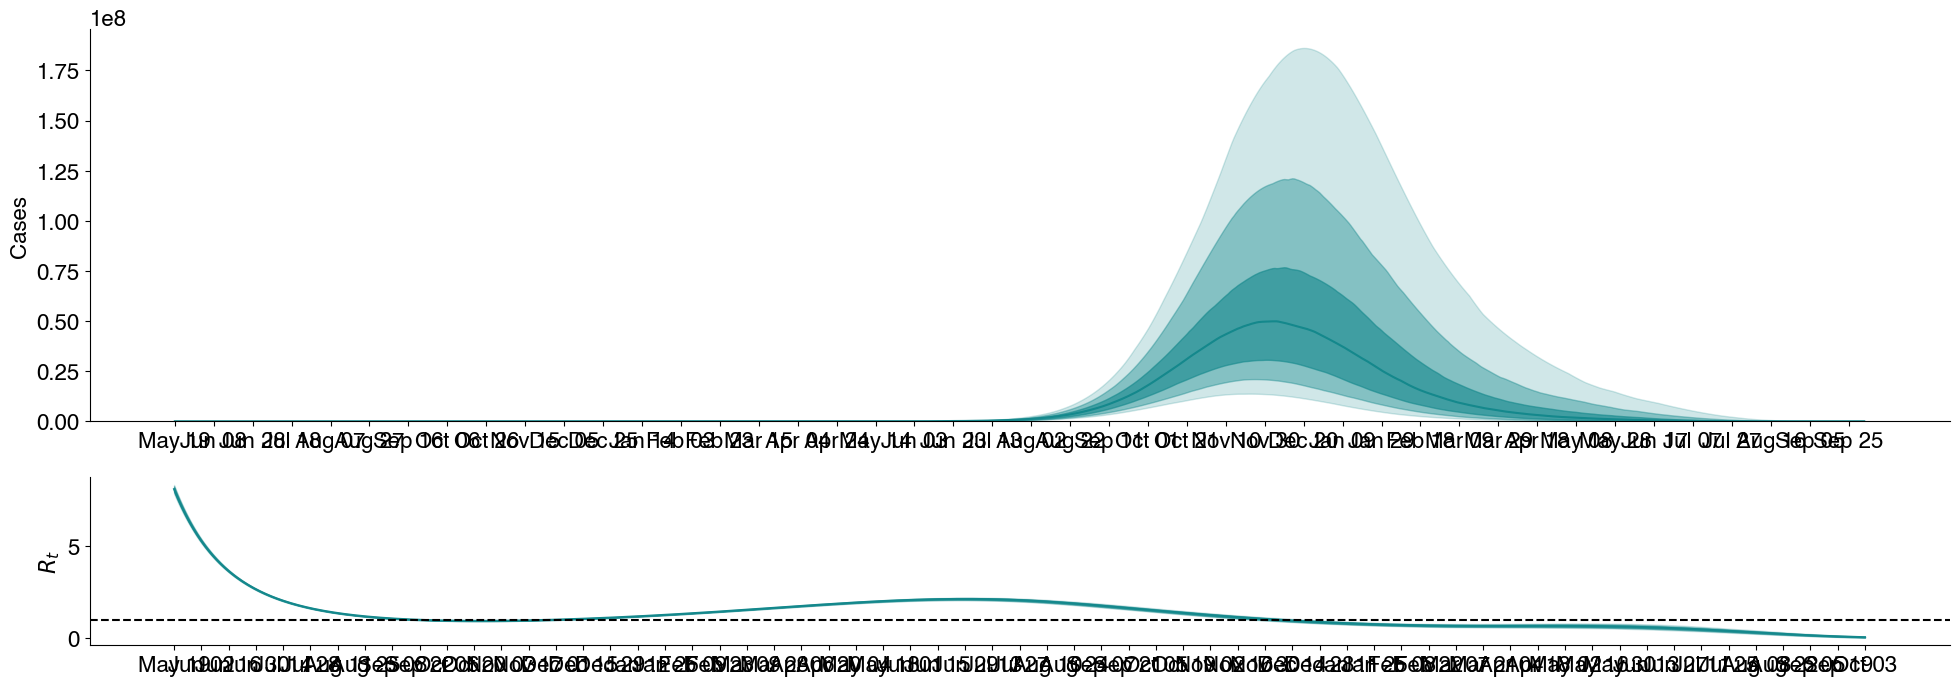

In [30]:
posterior = multiposterior["LA"]
plot_cute_posterior(posterior, main_color="#14888c")

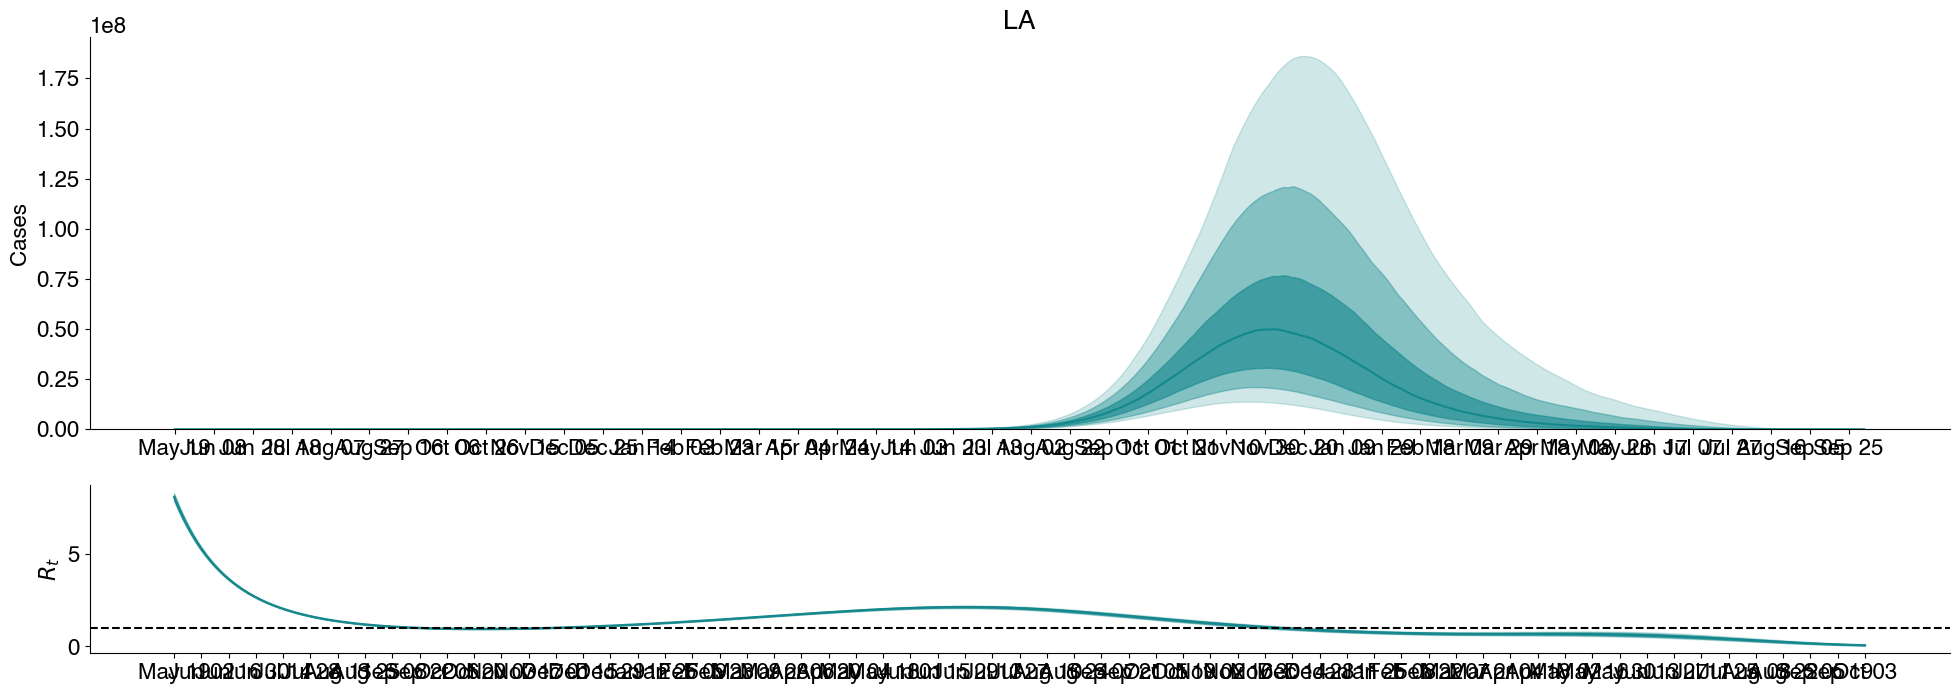

In [31]:
for name, post in multiposterior.locator.items():
    plot_cute_posterior(post, main_color="#14888c", title=name)

In [35]:
def get_site(
    samples, data, ps, name, site, forecast=False
):

    dates = data.dates

    # Unpack posterior
    site_name = site + "_forecast" if forecast else site
    site = samples[site_name]
    T = len(dates)

    if forecast:
        dates = forecast_dates(dates, T)

    # Compute medians and hdis for ps
    site_median = jnp.median(site, axis=0)

    site_hdis = [
        jnp.quantile(site, q=jnp.array([0.5 * (1 - p), 0.5 * (1 + p)]), axis=0)
        for p in ps
    ]

    site_dict = dict()
    site_dict["date"] = list(dates)
    site_dict["region"] = [name] * T
    site_dict[f"median_{site_name}"] = list(site_median)[-T:]
    for i, p in enumerate(ps):
        site_dict[f"{site_name}_upper_{round(ps[i] * 100)}"] = list(site_hdis[i][1, -T:])
        site_dict[f"{site_name}_lower_{round(ps[i] * 100)}"] = list(site_hdis[i][0, -T:])        
    return site_dict

In [36]:
def site_posteriors_to_dataframe(mp, site, ps):
    dfs = []
    for name, post in multiposterior.locator.items():
        site_dict_name = get_site(post.samples, post.data, ps, name, site, forecast=False)
        print(name)
        dfs.append(
            pd.DataFrame(site_dict_name)
        )
    return pd.concat(dfs)

In [37]:
Rt_estimates = site_posteriors_to_dataframe(multiposterior, "R", [0.95])

LA


In [38]:
incidence_estimates = site_posteriors_to_dataframe(multiposterior, "I_smooth", [0.95])

LA


In [39]:
prev_estimates = site_posteriors_to_dataframe(multiposterior, "prev", [0.95])

LA


In [40]:
Rt_estimates.to_csv("case-rt-estimates_region.tsv", index=False, sep="\t")
incidence_estimates.to_csv("case-incidence-estimates_region.tsv", index=False, sep="\t")
prev_estimates.to_csv("case-prevalence-estimates_region.tsv", index=False, sep="\t")